# Assignment 11
RGB image data를 학습해보자  
* Training data image
  + Shape: (?, 3, 64, 128)
    + 여러장의, RGB, 64x128 size의 이미지라고 가정하자
* Test data image
  + Shape: (?, 3, ?, ?)
    + 여러장의, RGB, size를 알 수 없는 이미지라고 가정하자
* Labels
  + image의 class는 2가지 이다
data folder의 구성을 참고하자
* Data folder 위치
  + 노트북 github의 data folder 2개를 적당한 위치에 카피해 사용한다

In [1]:
#import
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt

In [2]:
# Model
# Image의 size(64*128) 에 맞게 model을 생성하며
# RGB Imamge 이므로 채널이 3임에 유의한다.
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 Input shape=(?, 3, 64, 128)
        #    Conv     -> (?, 3*32, 64, 128)
        #    Pool     -> (?, 3*32, 32, 64)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3*32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 Input shape=(?, 3*32, 32, 64)
        #    Conv      ->(?, 3*64, 32, 64)
        #    Pool      ->(?, 3*64, 16, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(3*32, 3*64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 Linear 64x7x7 inputs -> 10 outputs
        self.fc = torch.nn.Linear(3*64*64*64, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [3]:
#런타임이 GPU로 설정되어있는지 확인한다.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from google.colab import drive
# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# parameters
learning_rate = 0.01
training_epochs = 5

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train data를 Drive에서 가져와 생성한다.
trans=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
train_data = dsets.ImageFolder(root='/content/drive/MyDrive/dummy/train', transform=trans)
data_loader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True)

total_batch = len(data_loader)

#학습이 loop에서 이루어진다.
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')


cuda
Learning started. It takes sometime.
[Epoch:    1] cost = 207.397522
[Epoch:    2] cost = 3.9054327
[Epoch:    3] cost = 0.803892016
[Epoch:    4] cost = 26.0002346
[Epoch:    5] cost = 78.704895
Learning Finished!


In [5]:
#test data를 Drive에서 가져와 생성한다.
trans=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_data = dsets.ImageFolder(root='/content/drive/MyDrive/dummy/test', transform=trans)
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))


with torch.no_grad():

  # test data를 이미지를 활용하기 위한 loop이다.
  for X, Y in test_set:
      X_test = X.to(device)
      Y_test = Y.to(device)

  # test image를 model에 적용시켰을 때 정확도를 출력한다.
  prediction = model(X_test)
  correct_prediction = torch.argmax(prediction, 1) == Y_test
  accuracy = correct_prediction.float().mean()
  # 예측값이 1.0 인것을 확인 할 수 있다.
  print('Accuracy:', accuracy.item())


  # test image중 랜덤으로 하나를 선택해 본다.
  r = random.randint(0, len(X) - 1)
  img_sample = X.data[r].view(1, 3, 256, 256).float().to(device)
  label_sample = Y.data[r].to(device)

  # image의 label과 model을 예측을 비교해 본다.
  # 동일함을 알 수 있다.
  print('Label: ', label_sample.item())
  sample_prediction = model(img_sample)
  print('Prediction: ', torch.argmax(sample_prediction, axis=1).item())

Accuracy: 0.925000011920929
Label:  1
Prediction:  1


In [17]:
# 예측이 사실임을 육안으로 확인하기 위해
# shape를 (64,128,3)으로 reshape된 변수를 생성해준다.
print(X[r].shape)
im2display = X[r].permute((1,2,0))
print(im2display.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256, 3])


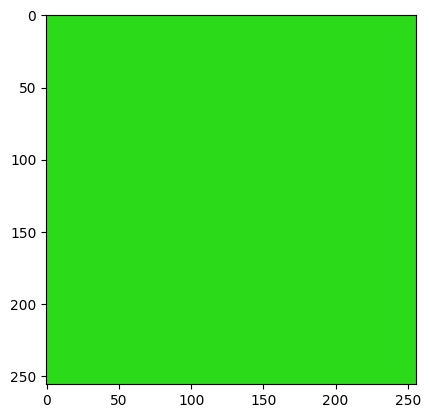

In [7]:
#이미지 출력을 확인한다.
plt.imshow(im2display,interpolation='nearest')
plt.show()

In [18]:
cd /content/drive/MyDrive/Colab\ Notebooks/temp

/content/drive/MyDrive/Colab Notebooks/temp


In [20]:
!git clone "https://github.com/18KimGunwook/for_test"

Cloning into 'for_test'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [21]:
!git init
!git config --global user.email "gukim98@gmail.com"
!git config --global user.name "18KimGunwook"

Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/temp/.git/


In [22]:
!git checkout -b branch_pr

Switched to a new branch 'branch_pr'


In [23]:
!git add .
!git commit -m "2018732061_김건욱_assignment_11.ipynb"

hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> 2018732061_HW4
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached 2018732061_HW4
hint: 
hint: See "git help submodule" for more information.
[branch_pr (root-commit) f7ab292] 2018732061_김건욱_assignment_11.ipynb
 4 files changed, 4 insertions(+)
 create mode 160000 2018732061_HW4
 create mode 160000 2018732061_HW5
 create mode 160000 2020732079_HW4
 create mode 160000 for_test
